In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import pickle
import io
gin.enter_interactive_mode()
from causal_util import load_env
from causal_util.helpers import lstdct2dctlst
from sparse_causal_model_learner_rl.loss.losses import fit_loss
from sparse_causal_model_learner_rl.loss.causal_discriminator import siamese_feature_discriminator_l2

from sparse_causal_model_learner_rl.metrics.context_rewrite import context_rewriter
from sparse_causal_model_learner_rl.visual.learner_visual import graph_for_matrices
from sparse_causal_model_learner_rl.config import Config
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL

In [2]:
load_config_files(['../sparse_causal_model_learner_rl/configs/kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1.gin',
                   '../sparse_causal_model_learner_rl/configs/kc_dec.gin',
                   '../keychest/config/5x5_1f1c1k_obs.gin'])

['kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1', 'kc_dec', '5x5_1f1c1k_obs']

In [3]:
gin.bind_parameter('Config.collect_remotely', True)
gin.bind_parameter('Config.n_collectors', 15)
gin.bind_parameter('Config.future_buffer_size', 50)

In [4]:
learner = CausalModelLearnerRL(Config(ray_kwargs={'address': '127.0.0.1:6379'}))

2021-02-05 01:41:30,017	INFO worker.py:651 -- Connecting to existing Ray cluster at address: 10.90.38.7:6379


Selecting name e3175ffc-674a-11eb-af1d-90e2baa1a248
Make environment KeyChest-v0 None {}


In [5]:
learner.create_trainables()

In [6]:
env = learner.env

In [7]:
losses = []
dplus = []

In [8]:
opt = torch.optim.Adam(lr=1e-3, params=learner.decoder.parameters())

In [9]:
for i in tqdm(range(1000)):
    if i % 10 == 0:
        ctx = learner.collect_and_get_context()
    
    opt.zero_grad()
    l_obj = siamese_feature_discriminator_l2(**ctx)
    loss = l_obj['loss']
    loss.backward()
    opt.step()
    losses.append(loss.item())
    dplus.append(l_obj['metrics']['distance_plus'])

(pid=32292) Make environment KeyChest-v0 None {}
(pid=32293) Make environment KeyChest-v0 None {}
(pid=32294) Make environment KeyChest-v0 None {}
(pid=32398) Make environment KeyChest-v0 None {}
(pid=32308) Make environment KeyChest-v0 None {}
(pid=32304) Make environment KeyChest-v0 None {}
(pid=32298) Make environment KeyChest-v0 None {}
(pid=32323) Make environment KeyChest-v0 None {}
(pid=32301) Make environment KeyChest-v0 None {}
(pid=32318) Make environment KeyChest-v0 None {}
(pid=32328) Make environment KeyChest-v0 None {}
(pid=32316) Make environment KeyChest-v0 None {}
(pid=32331) Make environment KeyChest-v0 None {}
(pid=32307) Make environment KeyChest-v0 None {}
(pid=32313) Make environment KeyChest-v0 None {}



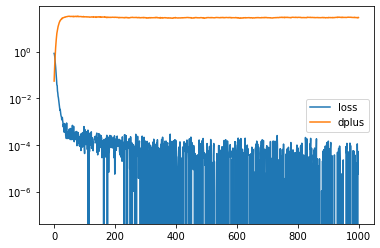

In [10]:
plt.plot(losses, label='loss')
plt.plot(dplus, label='dplus')
plt.yscale('log')
plt.legend()

In [11]:
np.mean(losses[-50:]), np.median(losses[-50:])

(1.9062378755734243e-05, 0.0)

In [12]:
features = learner.decoder(ctx['obs'])

In [13]:
f = features.detach().cpu().numpy()

In [14]:
f.shape

(5007, 30)

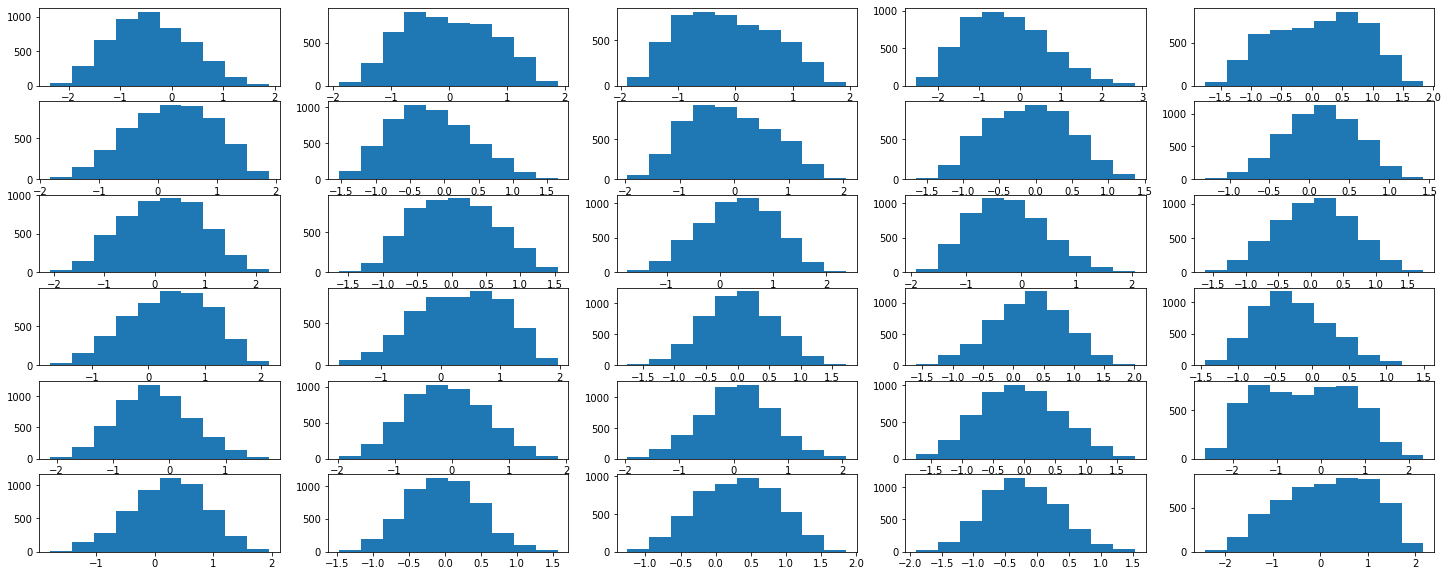

In [15]:
plt.figure(figsize=(25, 10))
for i_f in range(f.shape[1]):
    plt.subplot(6, 5, i_f + 1)
    plt.hist(f[:, i_f])

In [16]:
pd.DataFrame(f).std()

0     0.750492
1     0.765393
2     0.799642
3     0.990034
4     0.745586
5     0.708209
6     0.580060
7     0.762197
8     0.557706
9     0.457455
10    0.780901
11    0.576835
12    0.699452
13    0.674988
14    0.586024
15    0.719894
16    0.729063
17    0.551538
18    0.606529
19    0.500703
20    0.647840
21    0.668235
22    0.654775
23    0.641761
24    1.048280
25    0.632705
26    0.491081
27    0.563586
28    0.569429
29    0.922933
dtype: float32

<AxesSubplot:>

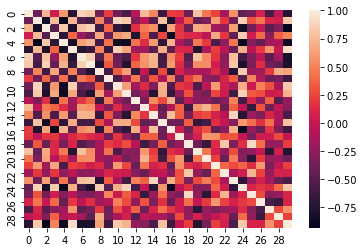

In [17]:
sns.heatmap(pd.DataFrame(f).corr())

In [18]:
env.engine.return_rgb = False

In [19]:
losses = []
metrics = []

In [20]:
gin.bind_parameter('model_gnn/FCCombinedModel.activation_cls', torch.nn.LeakyReLU)

In [21]:
learner.non_sparse_model.__init__(feature_shape=learner.feature_shape,
                                  action_shape=learner.action_shape,
                                  additional_feature_shape=learner.additional_feature_shape)
learner.non_sparse_model = learner.non_sparse_model.cuda()

In [22]:
learner.non_sparse_model.model.model.activation

[LeakyReLU(negative_slope=0.01),
 LeakyReLU(negative_slope=0.01),
 LeakyReLU(negative_slope=0.01),
 None]

In [23]:
learner.non_sparse_model

ManyNetworkCombinedModel(
  (model): WithInputSwitch(
    (switch): LearnableSwitchSimple()
    (model): FCCombinedModel(
      (fc01): CombinedLinearLayer()
      (fc02): CombinedLinearLayer()
      (fc03): CombinedLinearLayer()
      (fc04): CombinedLinearLayer()
    )
  )
)

In [24]:
learner.non_sparse_model.model.enable_switch

False

In [25]:
mins = None
maxes = None

In [26]:
def normalize(t, mins, maxes):
    return 2 * ((t - mins) / (1e-3 + maxes - mins) - 0.5)

In [27]:
class AdhocWorldModel(nn.Module):
    def __init__(self):
        super(AdhocWorldModel, self).__init__()
        self.fc1 = nn.Linear(in_features=34, out_features=60)
        self.fc2 = nn.Linear(in_features=60, out_features=60)
        self.fc3 = nn.Linear(in_features=60, out_features=60)
        self.fc4 = nn.Linear(in_features=60, out_features=32)
        self.activation = nn.Tanh()
        
    def forward(self, f_t, a_t, all):
        x = torch.cat([f_t, a_t], dim=1)
        x = self.fc1(x)
        x = self.activation(x)
        
        x = self.fc2(x)
        x = self.activation(x)
        
        x = self.fc3(x)
        x = self.activation(x)
        
        x = self.fc4(x)
        return x

In [28]:
#use_model = learner.non_sparse_model
use_model = AdhocWorldModel().cuda()

In [29]:
opt = torch.optim.Adam(lr=1e-3, params=use_model.parameters())

In [ ]:
for i in tqdm(range(1000)):
    if i % 10 == 0:
        ctx = learner.collect_and_get_context()
        
        if mins is None or maxes is None:
            print("Computing minmax")
            f_all = learner.decoder(ctx['obs'])
            mins = f_all.min(dim=0, keepdim=True).values.detach()
            maxes = f_all.max(dim=0, keepdim=True).values.detach()
        
        f_t1 = learner.decoder(ctx['obs_y']).detach()
        f_t = learner.decoder(ctx['obs_x']).detach()
        
        f_t1 = normalize(f_t1, mins, maxes)
        f_t = normalize(f_t, mins, maxes)
        
        add_features_y = torch.cat([ctx[k] for k in ctx['additional_feature_keys']], dim=1)
        f_t1 = torch.cat([f_t1, add_features_y], dim=1)
    f_t1_pred = use_model(
        f_t,
        ctx['action_x'],
        all=True)
    
    loss = nn.MSELoss()(f_t1, f_t1_pred)

    
    opt.zero_grad()
#     l_obj = context_rewriter(function=fit_loss, rewrite={'model': 'non_sparse_model'}, **ctx)
#     loss = l_obj['loss']
    loss.backward()
    opt.step()
    losses.append(loss.item())
#     metrics.append(l_obj['metrics'])

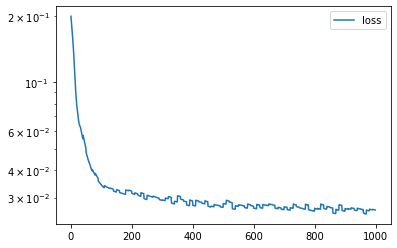

In [31]:
plt.plot(losses, label='loss')
#plt.plot(dplus, label='dplus')
plt.yscale('log')
plt.legend()

In [98]:
metrics_dct = lstdct2dctlst(metrics)
for key, vals in metrics_dct.items():
    if len(np.array(vals).shape) > 1: continue
    plt.plot(vals, label=key)
plt.legend()
plt.show()

IndexError: list index out of range

In [32]:
metrics_dct.keys()

dict_keys(['mean_feature', 'std_feature', 'min_feature', 'max_feature', 'std_feature_avg', 'inv_std_feature_avg'])